# Plan:
- Our probe labels a given dataset and tells us the estimated success rate (hardest-easiest)
- If it has a high success rate, this tells us that we will likely pass this problem (definitely will with more turns)
- If we have a low success rate, we should get a better model to look at our work, or increase the number of turns with the small model, or change to a better model.


In [ ]:
import pandas as pd
import numpy as np
import os
import uuid
import base64
from vllm import LLM, SamplingParams
from math_verify import parse, verify
from tqdm import tqdm
from transformers import AutoTokenizer
from utils import evaluate_responses, verify_answer
from collections import Counter

/opt/anaconda/envs/diff-direction/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


INFO 12-09 17:17:36 [__init__.py:241] Automatically detected platform cuda.


In [2]:
print (uuid.uuid1())

fa1d676e-d522-11f0-b6ea-c4cbe1caad28


In [3]:
def parse_answers(responses):
    PARSED_ANSWER_LIST = []
    for response in responses:
        try:
            parsed_anwer = parse(response)
            PARSED_ANSWER_LIST.append(parsed_anwer)
        except Exception:
            PARSED_ANSWER_LIST.append(response)
            print("\n***** can't parse answer so appending whole response ****** \n")
    return PARSED_ANSWER_LIST

In [4]:
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [6]:
MODEL_NAME = "Qwen/Qwen2.5-Math-1.5B-Instruct"
MODEL_ALIAS = MODEL_NAME.split("/")[-1]

In [18]:
DATASET_NAME = "AIME_1983_2024"

In [7]:
LABELLED_DATA_PATH = f"/VData/linna4335/llms_know_difficult/runs/{MODEL_ALIAS}/datasplits/{DATASET_NAME}_predicted_by_predicting_learnability.json"

In [9]:
df = pd.read_json(LABELLED_DATA_PATH)

In [13]:
MATH_PROMPT_FORMATTING = " Please put your final answer inside \\boxed{}."
df["formatted_prompt"] = df["question"].apply(lambda x: x + MATH_PROMPT_FORMATTING)
df["id"] = [str(uuid.uuid1()) for uid in range(len(df))]
df["b64id"] = df["question"].apply(lambda x: base64.b64encode(x.encode()))

In [15]:
df["predicted_difficulty"].describe()

count    933.000000
mean      -1.957820
std        0.796589
min       -3.916745
25%       -2.534953
50%       -2.039659
75%       -1.433164
max        0.851972
Name: predicted_difficulty, dtype: float64

In [16]:
df["predicted_difficulty_sigmoid"].describe()

count    933.000000
mean       0.148593
std        0.106876
min        0.019517
25%        0.073444
50%        0.115101
75%        0.192606
max        0.700981
Name: predicted_difficulty_sigmoid, dtype: float64

In [17]:
llm = LLM(model=MODEL_NAME, gpu_memory_utilization=0.6)

INFO 12-09 17:21:36 [utils.py:326] non-default args: {'model': 'Qwen/Qwen2.5-Math-1.5B-Instruct', 'gpu_memory_utilization': 0.6, 'disable_log_stats': True}
INFO 12-09 17:22:04 [__init__.py:711] Resolved architecture: Qwen2ForCausalLM


`torch_dtype` is deprecated! Use `dtype` instead!


INFO 12-09 17:22:04 [__init__.py:1750] Using max model len 4096


2025-12-09 17:22:08,959	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


INFO 12-09 17:22:09 [scheduler.py:222] Chunked prefill is enabled with max_num_batched_tokens=16384.
(EngineCore_0 pid=3665679) INFO 12-09 17:22:11 [core.py:636] Waiting for init message from front-end.
(EngineCore_0 pid=3665679) INFO 12-09 17:22:11 [core.py:74] Initializing a V1 LLM engine (v0.10.1.1) with config: model='Qwen/Qwen2.5-Math-1.5B-Instruct', speculative_config=None, tokenizer='Qwen/Qwen2.5-Math-1.5B-Instruct', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config={}, tokenizer_revision=None, trust_remote_code=False, dtype=torch.bfloat16, max_seq_len=4096, download_dir=None, load_format=auto, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto, device_config=cuda, decoding_config=DecodingConfig(backend='auto', disable_fallback=False, disable_any_whitespace=False, disable_additional_properties=False, reasoning_backend=''), observability_config=Observabi

Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]
Loading safetensors checkpoint shards: 100% Completed | 1/1 [00:00<00:00,  2.35it/s]
Loading safetensors checkpoint shards: 100% Completed | 1/1 [00:00<00:00,  2.34it/s]
(EngineCore_0 pid=3665679) 


(EngineCore_0 pid=3665679) INFO 12-09 17:23:00 [default_loader.py:262] Loading weights took 0.52 seconds
(EngineCore_0 pid=3665679) INFO 12-09 17:23:01 [gpu_model_runner.py:2007] Model loading took 2.8798 GiB and 38.436405 seconds
(EngineCore_0 pid=3665679) INFO 12-09 17:23:27 [backends.py:548] Using cache directory: /home/lina4335/.cache/vllm/torch_compile_cache/63465de3ab/rank_0_0/backbone for vLLM's torch.compile
(EngineCore_0 pid=3665679) INFO 12-09 17:23:27 [backends.py:559] Dynamo bytecode transform time: 25.71 s
(EngineCore_0 pid=3665679) INFO 12-09 17:23:31 [backends.py:161] Directly load the compiled graph(s) for dynamic shape from the cache, took 3.522 s
(EngineCore_0 pid=3665679) INFO 12-09 17:23:31 [monitor.py:34] torch.compile takes 25.71 s in total
(EngineCore_0 pid=3665679) INFO 12-09 17:23:33 [gpu_worker.py:276] Available KV cache memory: 38.98 GiB
(EngineCore_0 pid=3665679) INFO 12-09 17:23:34 [kv_cache_utils.py:849] GPU KV cache size: 1,459,856 tokens
(EngineCore_0 pi

Capturing CUDA graphs (mixed prefill-decode, PIECEWISE): 100%|██████████| 67/67 [00:01<00:00, 34.06it/s]


(EngineCore_0 pid=3665679) INFO 12-09 17:23:36 [gpu_model_runner.py:2708] Graph capturing finished in 2 secs, took 0.58 GiB
(EngineCore_0 pid=3665679) INFO 12-09 17:23:36 [core.py:214] init engine (profile, create kv cache, warmup model) took 35.46 seconds
INFO 12-09 17:23:37 [llm.py:298] Supported_tasks: ['generate']


In [19]:
PROMPTS = df["formatted_prompt"].to_list()
GTS = df["answer"].to_list()
PREDICTED_DIFFICULTIES = df["predicted_difficulty"].to_list()
PREDICTED_DIFFICULTIES_SIGMOID = df["predicted_difficulty_sigmoid"].to_list()

### Baseline Performance

In [23]:
PARAMS = SamplingParams(temperature=0.0, max_tokens=3000)

In [ ]:
outputs = llm.generate(PROMPTS, PARAMS)
RESP = []
TOKEN_LENGTHS = []
for output in outputs:
    prompt = output.prompt
    generated_text = output.outputs[0].text
    token_length = len(output.outputs[0].token_ids)
    RESP.append(generated_text)
    TOKEN_LENGTHS.append(token_length)

Processed prompts: 100%|██████████| 933/933 [00:43<00:00, 21.65it/s, est. speed input: 2622.10 toks/s, output: 28568.86 toks/s]


In [28]:
is_correct, accuracy, num_correct, total = evaluate_responses(RESP, GTS)
print(f"Baseline Accuracy: {accuracy:.2f}% ({num_correct}/{total})")

Baseline Accuracy: 28.30% (264/933)


In [ ]:
baseline_df = df.copy()
baseline_df["is_correct"] = is_correct
baseline_df["response"] = RESP
baseline_df["token_length"] = TOKEN_LENGTHS
# For baseline, all stats are the same since it's a single generation
baseline_df["token_length_min"] = TOKEN_LENGTHS
baseline_df["token_length_max"] = TOKEN_LENGTHS
baseline_df["token_length_median"] = TOKEN_LENGTHS
baseline_df["token_length_mean"] = TOKEN_LENGTHS

In [30]:
MAJORITY_VOTE_RESULTS_DIR = f"../predicting_learnability/MAJORITY_VOTE_DATA/{DATASET_NAME}"
os.makedirs(MAJORITY_VOTE_RESULTS_DIR, exist_ok=True)

In [34]:
str(baseline_df["id"].iloc[0])

'54867ee8-d523-11f0-b6ea-c4cbe1caad28'

In [35]:
baseline_df["id"] = baseline_df["id"].apply(lambda x: str(x))

In [36]:
baseline_df.to_parquet(f"{MAJORITY_VOTE_RESULTS_DIR}/{MODEL_ALIAS}_baseline_df.parquet")

### RQ1: Which type of problems benefit from increased compute?

In [37]:
# we will majority vote each problem and observe which ones benefit from more compute.

In [38]:
MAJORITY_VOTE_DF = df.copy()

In [39]:
NUM_SAMPLES = 10
PARAMS = SamplingParams(temperature=0.6, max_tokens=3000)

In [ ]:
PROMPT_RESPONSE_STORE = dict()
PROMPT_PARSED_ANSWER_STORE = dict()
PROMPT_TOKEN_LENGTHS_STORE = dict()
MAJORITY_VOTE_CORRECT_STORE = []
MAJORITY_VOTE_ANSWER_STORE = []
TOKEN_LENGTH_MIN_STORE = []
TOKEN_LENGTH_MAX_STORE = []
TOKEN_LENGTH_MEDIAN_STORE = []
TOKEN_LENGTH_MEAN_STORE = []

# for each prompt, generate responses, extract answers,
# choose most common answer and verify correctness
for idx, SINGLE_PROMPT in enumerate(PROMPTS):
    REPEATED_SINGLE_PROMPTS = [SINGLE_PROMPT] * NUM_SAMPLES
    REPEATED_SINGLE_GTS = [GTS[idx]] * NUM_SAMPLES
    outputs = llm.generate(REPEATED_SINGLE_PROMPTS, PARAMS)
    SINGLE_PROMPT_RESPONSES = []
    SINGLE_PROMPT_TOKEN_LENGTHS = []
    
    for output in outputs:
        prompt = output.prompt
        generated_text = output.outputs[0].text
        token_length = len(output.outputs[0].token_ids)
        SINGLE_PROMPT_RESPONSES.append(generated_text)
        SINGLE_PROMPT_TOKEN_LENGTHS.append(token_length)
    
    # store all the responses per question
    PROMPT_RESPONSE_STORE[idx] = SINGLE_PROMPT_RESPONSES
    PROMPT_TOKEN_LENGTHS_STORE[idx] = SINGLE_PROMPT_TOKEN_LENGTHS
    
    # Calculate token length statistics
    TOKEN_LENGTH_MIN_STORE.append(min(SINGLE_PROMPT_TOKEN_LENGTHS))
    TOKEN_LENGTH_MAX_STORE.append(max(SINGLE_PROMPT_TOKEN_LENGTHS))
    TOKEN_LENGTH_MEDIAN_STORE.append(np.median(SINGLE_PROMPT_TOKEN_LENGTHS))
    TOKEN_LENGTH_MEAN_STORE.append(np.mean(SINGLE_PROMPT_TOKEN_LENGTHS))

    SINGLE_PARSED_ANSWER_LIST = parse_answers(SINGLE_PROMPT_RESPONSES)
    PROMPT_PARSED_ANSWER_STORE[idx] = SINGLE_PARSED_ANSWER_LIST
    SINGLE_PARSED_ANSWER_LIST_OPTION1 = [temp_ans[0] for temp_ans in SINGLE_PARSED_ANSWER_LIST]
    SINGLE_PARSED_ANSWER_LIST_OPTION2 = [temp_ans[1] for temp_ans in SINGLE_PARSED_ANSWER_LIST]

    FINAL_SINLE_PARSED_ANSWER_LIST = SINGLE_PARSED_ANSWER_LIST_OPTION1 + SINGLE_PARSED_ANSWER_LIST_OPTION2

    MAJORITY_VOTE_ANSWER =  Counter(FINAL_SINLE_PARSED_ANSWER_LIST).most_common(1)[0][0]

    IS_CORRECT = verify(parse(f"${REPEATED_SINGLE_GTS[0]}$"), MAJORITY_VOTE_ANSWER)
    MAJORITY_VOTE_CORRECT_STORE.append(IS_CORRECT)
    MAJORITY_VOTE_ANSWER_STORE.append(MAJORITY_VOTE_ANSWER)

MAJORITY_VOTE_DF["is_correct"] = MAJORITY_VOTE_CORRECT_STORE
MAJORITY_VOTE_DF["majority_answer"] = MAJORITY_VOTE_ANSWER_STORE
MAJORITY_VOTE_DF["token_length_min"] = TOKEN_LENGTH_MIN_STORE
MAJORITY_VOTE_DF["token_length_max"] = TOKEN_LENGTH_MAX_STORE
MAJORITY_VOTE_DF["token_length_median"] = TOKEN_LENGTH_MEDIAN_STORE
MAJORITY_VOTE_DF["token_length_mean"] = TOKEN_LENGTH_MEAN_STORE

print(f"\nMajority Vote Accuracy: {MAJORITY_VOTE_DF["is_correct"].mean() * 100:.2f}%, ({MAJORITY_VOTE_DF["is_correct"].sum()}/{len(MAJORITY_VOTE_DF)})\n")

Processed prompts: 100%|██████████| 10/10 [00:09<00:00,  1.08it/s, est. speed input: 204.23 toks/s, output: 958.89 toks/s]


Majority Vote Accuracy: 37.41%



In [56]:
print(f"\nMajority Vote Accuracy: {MAJORITY_VOTE_DF["is_correct"].mean() * 100:.2f}%, ({MAJORITY_VOTE_DF["is_correct"].sum()}/{len(MAJORITY_VOTE_DF)})\n")


Majority Vote Accuracy: 37.41%, (349/933)



In [ ]:
MAJORITY_VOTE_DF_COPY = MAJORITY_VOTE_DF.drop(columns=['majority_answer'])

In [166]:
from scipy.stats import spearmanr
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve

In [59]:
MAJORITY_VOTE_DF_COPY["is_correct_num"] = MAJORITY_VOTE_DF_COPY["is_correct"].astype(int)
baseline_df["is_correct_num"] = baseline_df["is_correct"].astype(int)

In [58]:
spearmanr(MAJORITY_VOTE_DF_COPY["predicted_difficulty"], MAJORITY_VOTE_DF_COPY["is_correct_num"])

SignificanceResult(statistic=0.06502821463193635, pvalue=0.04706339960423842)

In [60]:
spearmanr(baseline_df["predicted_difficulty"], baseline_df["is_correct_num"])

SignificanceResult(statistic=0.07067799052492924, pvalue=0.03087589172705077)

In [50]:
MAJORITY_VOTE_DF_COPY.to_parquet(f"{MAJORITY_VOTE_RESULTS_DIR}/{MODEL_ALIAS}_majority_vote_{NUM_SAMPLES}_df.parquet")

In [51]:
PROMPT_PARSED_ANSWER_STORE[0]

[[60, '60'],
 [60, '60'],
 [60, '60'],
 [60, '60'],
 [60, '60'],
 [60, '60'],
 [60, '60'],
 [60, '60'],
 [1/60, '\\frac{1}{60}'],
 [60, '60']]

In [ ]:
GTS[0]

[70, 588, 16, 117, 279, 504, 821, 77, 62, 81, 259, 510, 204, 60, 735]

In [52]:
GTS[0:5]

['60', '15', '20', '26', '4']

In [53]:
MAJORITY_VOTE_ANSWER_STORE[0:5]

[60, 15, 20, 26, 4]

In [64]:
baseline_correctness = baseline_df["is_correct"].tolist()
majority_vote_correctness = MAJORITY_VOTE_DF_COPY["is_correct_num"].tolist()

In [68]:
COMPARISON_DICT = dict()

In [70]:
COMPARISON_DICT["problem"] = baseline_df["question"].tolist()
COMPARISON_DICT["id"] = baseline_df["id"].tolist()
COMPARISON_DICT["baseline_is_correct"] = baseline_correctness
COMPARISON_DICT["majority_vote_is_correct"] = majority_vote_correctness
COMPARISON_DICT["success_rate"] = baseline_df["predicted_difficulty"].tolist()
COMPARISON_DICT["success_rate_sigmoid"] = baseline_df["predicted_difficulty_sigmoid"].tolist()
COMPARISON_DICT = pd.DataFrame(COMPARISON_DICT)

In [72]:
COMPARISON_DICT["delta_majority_vote"] = COMPARISON_DICT["majority_vote_is_correct"] - COMPARISON_DICT["baseline_is_correct"]

In [75]:
COMPARISON_DICT["delta_majority_vote"].value_counts()

delta_majority_vote
 0    804
 1    107
-1     22
Name: count, dtype: int64

In [76]:
spearmanr(COMPARISON_DICT["success_rate"], COMPARISON_DICT["delta_majority_vote"].tolist())

SignificanceResult(statistic=-0.0019492259531215452, pvalue=0.9525861701302913)

## Analysis: Effect of Majority Voting by Difficulty

We'll analyze:
1. **Difficulty bins**: Group problems by predicted difficulty
2. **Improvement rate**: % of problems that improved with majority voting in each bin
3. **Baseline vs Majority Vote**: Accuracy comparison across difficulty levels
4. **Statistical correlation**: Between difficulty and majority vote benefit

In [89]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_style("whitegrid")

In [90]:
# Create difficulty bins (e.g., quartiles or quintiles)
COMPARISON_DICT['difficulty_bin'] = pd.qcut(
    COMPARISON_DICT['success_rate'], 
    q=5, 
    labels=['Very Hard', 'Hard', 'Medium', 'Easy', 'Very Easy']
)

# Alternative: use sigmoid-based difficulty
# COMPARISON_DICT['difficulty_bin'] = pd.qcut(
#     COMPARISON_DICT['success_rate_sigmoid'], 
#     q=5, 
#     labels=['Very Hard', 'Hard', 'Medium', 'Easy', 'Very Easy']
# )

In [91]:
# 1. Calculate metrics by difficulty bin
results_by_difficulty = COMPARISON_DICT.groupby('difficulty_bin').agg({
    'baseline_is_correct': ['mean', 'sum', 'count'],
    'majority_vote_is_correct': ['mean', 'sum'],
    'delta_majority_vote': ['mean', 'sum'],
    'success_rate': 'mean'
}).round(4)

results_by_difficulty.columns = ['_'.join(col).strip() for col in results_by_difficulty.columns.values]
results_by_difficulty = results_by_difficulty.rename(columns={
    'baseline_is_correct_mean': 'baseline_accuracy',
    'baseline_is_correct_sum': 'baseline_correct_count',
    'baseline_is_correct_count': 'total_problems',
    'majority_vote_is_correct_mean': 'majority_vote_accuracy',
    'majority_vote_is_correct_sum': 'majority_vote_correct_count',
    'delta_majority_vote_mean': 'avg_improvement',
    'delta_majority_vote_sum': 'problems_improved',
    'success_rate_mean': 'avg_predicted_difficulty'
})

print("Performance by Difficulty Bin:")
results_by_difficulty

Performance by Difficulty Bin:


/tmp/ipykernel_3453129/2830206355.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  results_by_difficulty = COMPARISON_DICT.groupby('difficulty_bin').agg({


,baseline_accuracy,baseline_correct_count,total_problems,majority_vote_accuracy,majority_vote_correct_count,avg_improvement,problems_improved,avg_predicted_difficulty
difficulty_bin,,,,,,,,
Very Hard,0.1818,34,187,0.2781,52,0.0963,18,-2.9766
Hard,0.3011,56,186,0.3710,69,0.0699,13,-2.4530
Medium,0.3476,65,187,0.4439,83,0.0963,18,-2.0286
Easy,0.2688,50,186,0.3871,72,0.1183,22,-1.5473
Very Easy,0.3155,59,187,0.3904,73,0.0749,14,-0.7840


In [92]:
# 2. Calculate improvement rate (% of problems that benefited from majority voting)
results_by_difficulty['improvement_rate'] = (
    results_by_difficulty['problems_improved'] / results_by_difficulty['total_problems'] * 100
).round(2)

# Calculate absolute improvement
results_by_difficulty['absolute_improvement'] = (
    results_by_difficulty['majority_vote_accuracy'] - results_by_difficulty['baseline_accuracy']
).round(4)

print("\nImprovement Metrics:")
results_by_difficulty[['baseline_accuracy', 'majority_vote_accuracy', 
                             'absolute_improvement', 'improvement_rate', 'problems_improved']]


Improvement Metrics:


,baseline_accuracy,majority_vote_accuracy,absolute_improvement,improvement_rate,problems_improved
difficulty_bin,,,,,
Very Hard,0.1818,0.2781,0.0963,9.63,18
Hard,0.3011,0.3710,0.0699,6.99,13
Medium,0.3476,0.4439,0.0963,9.63,18
Easy,0.2688,0.3871,0.1183,11.83,22
Very Easy,0.3155,0.3904,0.0749,7.49,14


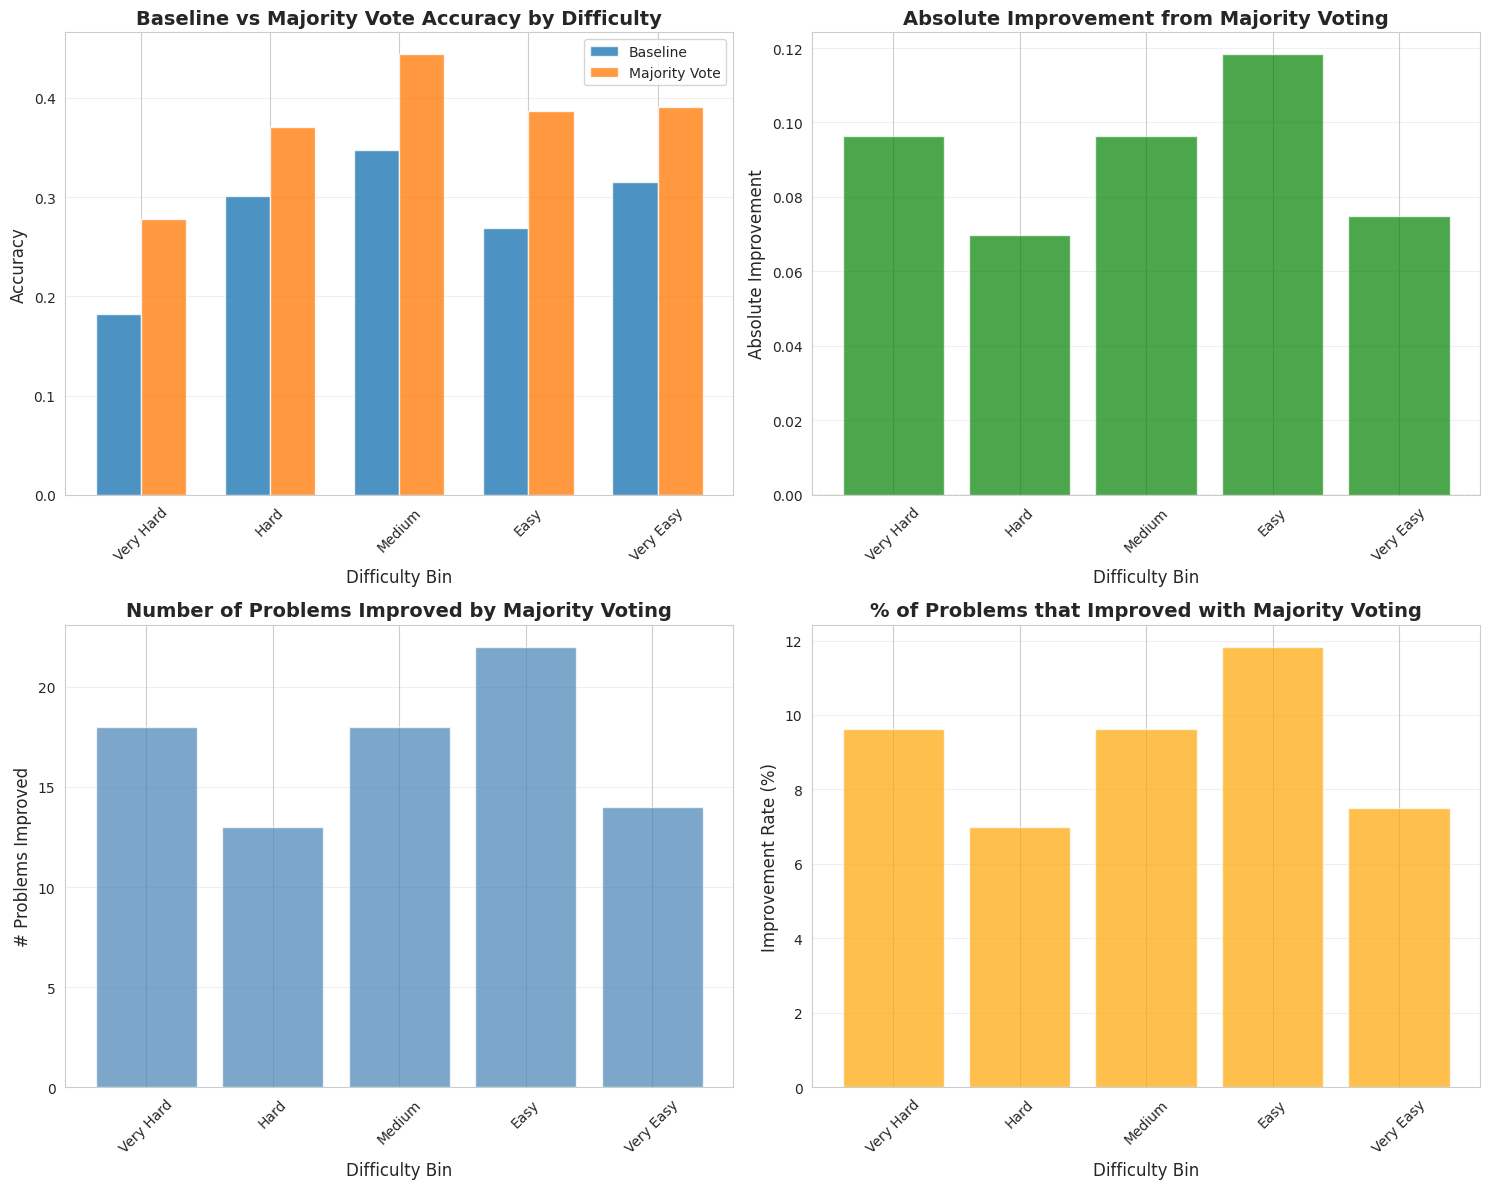

In [83]:
# 3. Visualize: Accuracy comparison across difficulty levels
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Baseline vs Majority Vote Accuracy
ax1 = axes[0, 0]
x_pos = np.arange(len(results_by_difficulty))
width = 0.35
ax1.bar(x_pos - width/2, results_by_difficulty['baseline_accuracy'], 
        width, label='Baseline', alpha=0.8)
ax1.bar(x_pos + width/2, results_by_difficulty['majority_vote_accuracy'], 
        width, label='Majority Vote', alpha=0.8)
ax1.set_xlabel('Difficulty Bin', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.set_title('Baseline vs Majority Vote Accuracy by Difficulty', fontsize=14, fontweight='bold')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(results_by_difficulty.index, rotation=45)
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Plot 2: Absolute Improvement
ax2 = axes[0, 1]
colors = ['red' if x < 0 else 'green' for x in results_by_difficulty['absolute_improvement']]
ax2.bar(results_by_difficulty.index, results_by_difficulty['absolute_improvement'], 
        color=colors, alpha=0.7)
ax2.set_xlabel('Difficulty Bin', fontsize=12)
ax2.set_ylabel('Absolute Improvement', fontsize=12)
ax2.set_title('Absolute Improvement from Majority Voting', fontsize=14, fontweight='bold')
ax2.axhline(y=0, color='black', linestyle='--', linewidth=0.8)
ax2.tick_params(axis='x', rotation=45)
ax2.grid(axis='y', alpha=0.3)

# Plot 3: Number of Problems Improved
ax3 = axes[1, 0]
ax3.bar(results_by_difficulty.index, results_by_difficulty['problems_improved'], 
        color='steelblue', alpha=0.7)
ax3.set_xlabel('Difficulty Bin', fontsize=12)
ax3.set_ylabel('# Problems Improved', fontsize=12)
ax3.set_title('Number of Problems Improved by Majority Voting', fontsize=14, fontweight='bold')
ax3.tick_params(axis='x', rotation=45)
ax3.grid(axis='y', alpha=0.3)

# Plot 4: Improvement Rate (%)
ax4 = axes[1, 1]
ax4.bar(results_by_difficulty.index, results_by_difficulty['improvement_rate'], 
        color='orange', alpha=0.7)
ax4.set_xlabel('Difficulty Bin', fontsize=12)
ax4.set_ylabel('Improvement Rate (%)', fontsize=12)
ax4.set_title('% of Problems that Improved with Majority Voting', fontsize=14, fontweight='bold')
ax4.tick_params(axis='x', rotation=45)
ax4.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(f'{MAJORITY_VOTE_RESULTS_DIR}/{MODEL_ALIAS}_difficulty_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

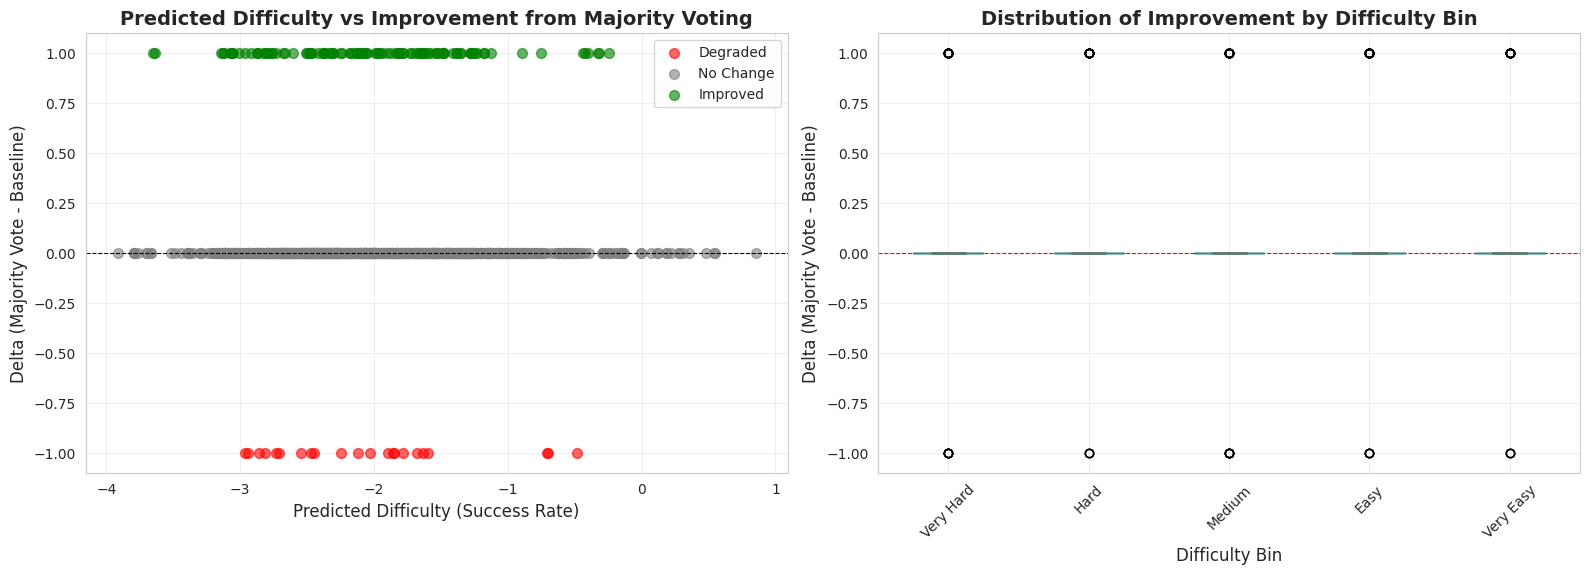

In [84]:
# 4. Scatter plot: Predicted Difficulty vs Improvement
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Scatter: Difficulty vs Delta (improvement)
ax1 = axes[0]
colors = COMPARISON_DICT['delta_majority_vote'].map({-1: 'red', 0: 'gray', 1: 'green'})
labels = {-1: 'Degraded', 0: 'No Change', 1: 'Improved'}
for val, color, label in [(-1, 'red', 'Degraded'), (0, 'gray', 'No Change'), (1, 'green', 'Improved')]:
    mask = COMPARISON_DICT['delta_majority_vote'] == val
    ax1.scatter(COMPARISON_DICT[mask]['success_rate'], 
                COMPARISON_DICT[mask]['delta_majority_vote'],
                c=color, label=label, alpha=0.6, s=50)
ax1.set_xlabel('Predicted Difficulty (Success Rate)', fontsize=12)
ax1.set_ylabel('Delta (Majority Vote - Baseline)', fontsize=12)
ax1.set_title('Predicted Difficulty vs Improvement from Majority Voting', fontsize=14, fontweight='bold')
ax1.legend()
ax1.axhline(y=0, color='black', linestyle='--', linewidth=0.8)
ax1.grid(alpha=0.3)

# Box plot: Delta by difficulty bin
ax2 = axes[1]
COMPARISON_DICT.boxplot(column='delta_majority_vote', by='difficulty_bin', ax=ax2)
ax2.set_xlabel('Difficulty Bin', fontsize=12)
ax2.set_ylabel('Delta (Majority Vote - Baseline)', fontsize=12)
ax2.set_title('Distribution of Improvement by Difficulty Bin', fontsize=14, fontweight='bold')
ax2.get_figure().suptitle('')  # Remove auto title
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)
ax2.axhline(y=0, color='red', linestyle='--', linewidth=0.8)
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(f'{MAJORITY_VOTE_RESULTS_DIR}/{MODEL_ALIAS}_difficulty_scatter_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

In [93]:
# 5. Statistical Analysis
from scipy.stats import chi2_contingency, pearsonr

# Contingency table: difficulty bin vs improvement
contingency = pd.crosstab(COMPARISON_DICT['difficulty_bin'], 
                          COMPARISON_DICT['delta_majority_vote'])
print("\nContingency Table (Difficulty Bin vs Delta):")
print(contingency)
print("\n")

# Chi-square test
chi2, p_value, dof, expected = chi2_contingency(contingency)
print(f"Chi-Square Test:")
print(f"  Chi2 statistic: {chi2:.4f}")
print(f"  P-value: {p_value:.6f}")
print(f"  Degrees of freedom: {dof}")
print(f"  Significant at α=0.05: {'Yes' if p_value < 0.05 else 'No'}")
print("\n")

# Correlation: Difficulty vs Delta
spearman_corr, spearman_p = spearmanr(COMPARISON_DICT['success_rate'], 
                                       COMPARISON_DICT['delta_majority_vote'])
print(f"Spearman Correlation (Difficulty vs Delta):")
print(f"  Correlation: {spearman_corr:.4f}")
print(f"  P-value: {spearman_p:.6f}")
print("\n")

# Pearson correlation
pearson_corr, pearson_p = pearsonr(COMPARISON_DICT['success_rate'], 
                                    COMPARISON_DICT['delta_majority_vote'])
print(f"Pearson Correlation (Difficulty vs Delta):")
print(f"  Correlation: {pearson_corr:.4f}")
print(f"  P-value: {pearson_p:.6f}")


Contingency Table (Difficulty Bin vs Delta):
delta_majority_vote  -1    0   1
difficulty_bin                  
Very Hard             6  157  24
Hard                  3  167  16
Medium                6  157  24
Easy                  4  156  26
Very Easy             3  167  17


Chi-Square Test:
  Chi2 statistic: 6.7761
  P-value: 0.560975
  Degrees of freedom: 8
  Significant at α=0.05: No


Spearman Correlation (Difficulty vs Delta):
  Correlation: -0.0019
  P-value: 0.952586


Pearson Correlation (Difficulty vs Delta):
  Correlation: -0.0104
  P-value: 0.750525


In [94]:
# 6. Detailed breakdown: Which problems improved, degraded, or stayed the same
improved_problems = COMPARISON_DICT[COMPARISON_DICT['delta_majority_vote'] == 1].copy()
degraded_problems = COMPARISON_DICT[COMPARISON_DICT['delta_majority_vote'] == -1].copy()
unchanged_problems = COMPARISON_DICT[COMPARISON_DICT['delta_majority_vote'] == 0].copy()

print(f"Summary Statistics:")
print(f"  Total problems: {len(COMPARISON_DICT)}")
print(f"  Improved with majority voting: {len(improved_problems)} ({len(improved_problems)/len(COMPARISON_DICT)*100:.2f}%)")
print(f"  Degraded with majority voting: {len(degraded_problems)} ({len(degraded_problems)/len(COMPARISON_DICT)*100:.2f}%)")
print(f"  Unchanged with majority voting: {len(unchanged_problems)} ({len(unchanged_problems)/len(COMPARISON_DICT)*100:.2f}%)")
print("\n")

print(f"Average Difficulty by Outcome:")
print(f"  Improved problems - Mean difficulty: {improved_problems['success_rate'].mean():.4f}")
print(f"  Degraded problems - Mean difficulty: {degraded_problems['success_rate'].mean():.4f}")
print(f"  Unchanged problems - Mean difficulty: {unchanged_problems['success_rate'].mean():.4f}")
print("\n")
print(f"Average Difficulty sigmoid by Outcome:")
print(f"  Improved problems - Mean difficulty: {improved_problems['success_rate_sigmoid'].mean():.4f}")
print(f"  Degraded problems - Mean difficulty: {degraded_problems['success_rate_sigmoid'].mean():.4f}")
print(f"  Unchanged problems - Mean difficulty: {unchanged_problems['success_rate_sigmoid'].mean():.4f}")

Summary Statistics:
  Total problems: 933
  Improved with majority voting: 107 (11.47%)
  Degraded with majority voting: 22 (2.36%)
  Unchanged with majority voting: 804 (86.17%)


Average Difficulty by Outcome:
  Improved problems - Mean difficulty: -2.0026
  Degraded problems - Mean difficulty: -2.0490
  Unchanged problems - Mean difficulty: -1.9494


Average Difficulty sigmoid by Outcome:
  Improved problems - Mean difficulty: 0.1396
  Degraded problems - Mean difficulty: 0.1345
  Unchanged problems - Mean difficulty: 0.1502


In [103]:
print(f"Median Difficulty by Outcome:")
print(f"  Improved problems - median success rate: {improved_problems['success_rate'].median():.4f}")
print(f"  Degraded problems - median success rate: {degraded_problems['success_rate'].median():.4f}")
print(f"  Unchanged problems - median success rate: {unchanged_problems['success_rate'].median():.4f}")

Median Difficulty by Outcome:
  Improved problems - median success rate: -1.9958
  Degraded problems - median success rate: -2.0763
  Unchanged problems - median success rate: -2.0403


## Alternative Analysis: Using Continuous Difficulty Scores

Instead of binning, let's look at the relationship between continuous difficulty predictions and improvement.

/tmp/ipykernel_3453129/914159717.py:74: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  baseline_by_diff = COMPARISON_DICT.groupby(difficulty_bins_viz)['baseline_is_correct'].mean()
/tmp/ipykernel_3453129/914159717.py:85: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  improvement_by_diff = COMPARISON_DICT.groupby(difficulty_bins_viz)['delta_majority_vote'].mean()


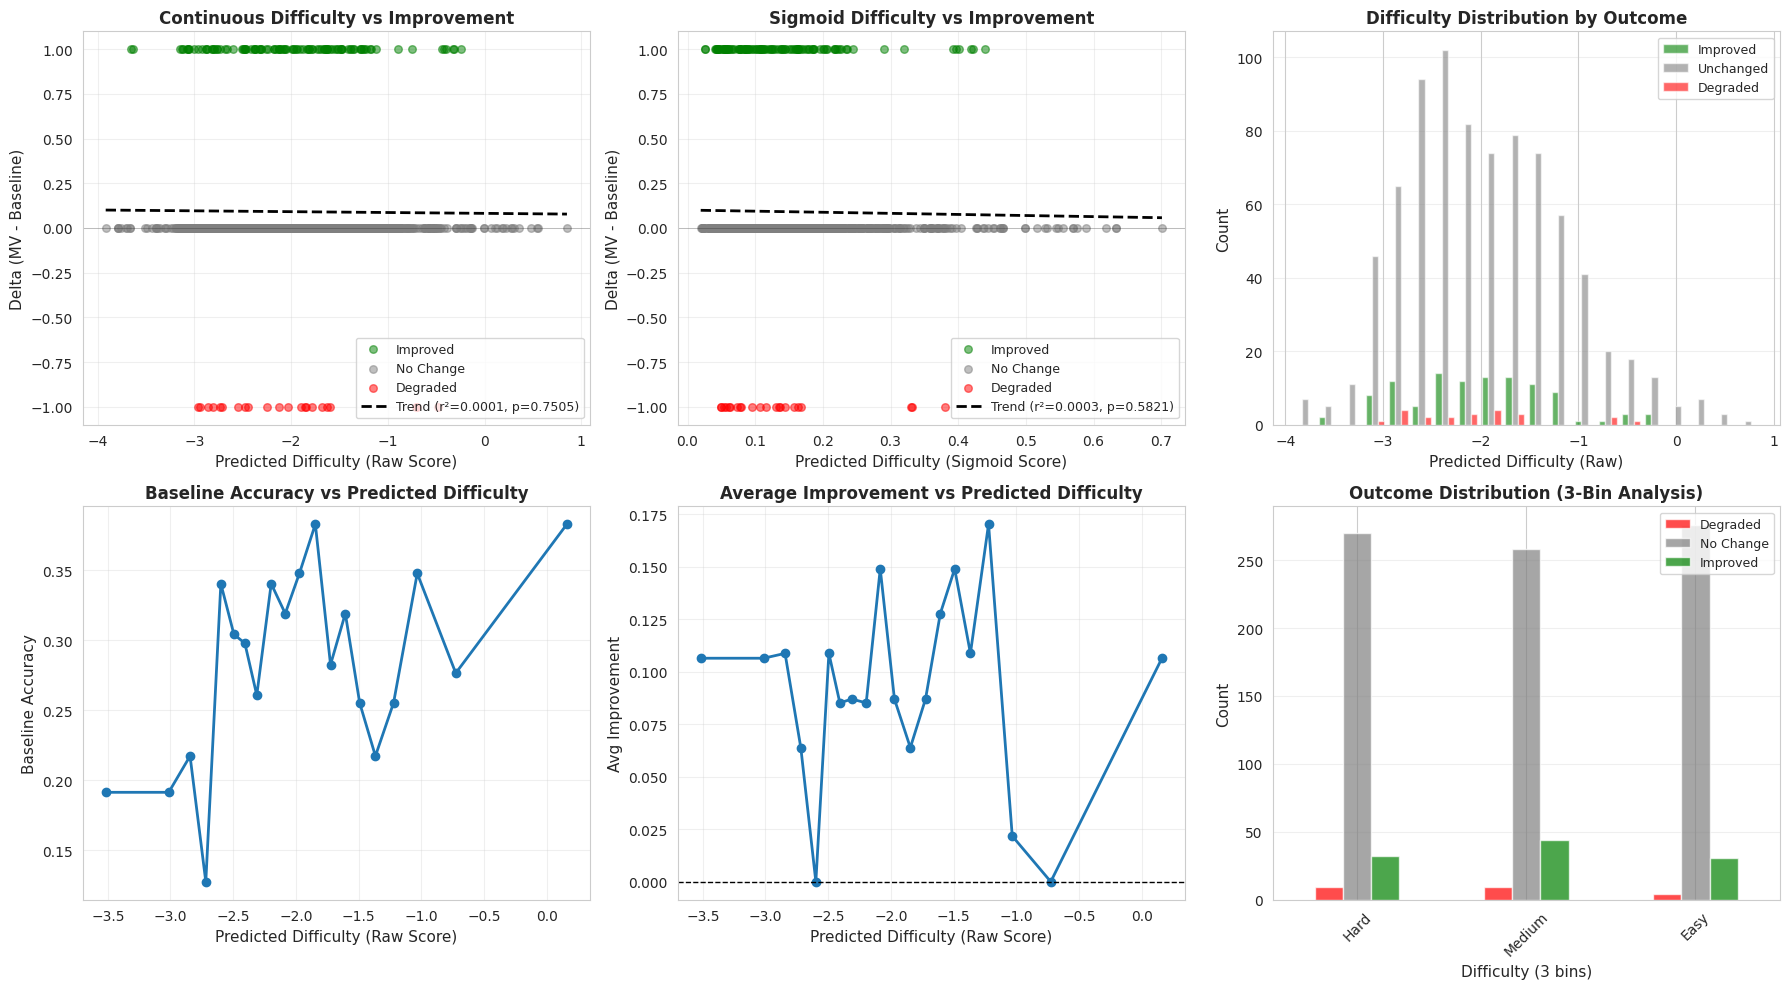


Linear Regression Results:
Raw Difficulty: r²=0.0001, slope=-0.0047, p=0.7505
Sigmoid Difficulty: r²=0.0003, slope=-0.0609, p=0.5821


In [97]:
# Visualize continuous relationship
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Plot 1: Scatter with regression line (raw difficulty scores)
ax1 = axes[0, 0]
for val, color, label in [(1, 'green', 'Improved'), (0, 'gray', 'No Change'), (-1, 'red', 'Degraded')]:
    mask = COMPARISON_DICT['delta_majority_vote'] == val
    ax1.scatter(COMPARISON_DICT[mask]['success_rate'], 
                COMPARISON_DICT[mask]['delta_majority_vote'],
                c=color, label=label, alpha=0.5, s=30)

# Add trend line
from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress(
    COMPARISON_DICT['success_rate'], 
    COMPARISON_DICT['delta_majority_vote']
)
x_line = np.linspace(COMPARISON_DICT['success_rate'].min(), 
                     COMPARISON_DICT['success_rate'].max(), 100)
y_line = slope * x_line + intercept
ax1.plot(x_line, y_line, 'k--', linewidth=2, 
         label=f'Trend (r²={r_value**2:.4f}, p={p_value:.4f})')

ax1.set_xlabel('Predicted Difficulty (Raw Score)', fontsize=11)
ax1.set_ylabel('Delta (MV - Baseline)', fontsize=11)
ax1.set_title('Continuous Difficulty vs Improvement', fontsize=12, fontweight='bold')
ax1.axhline(y=0, color='black', linestyle='-', linewidth=0.5, alpha=0.3)
ax1.legend(fontsize=9)
ax1.grid(alpha=0.3)

# Plot 2: Sigmoid difficulty scores
ax2 = axes[0, 1]
for val, color, label in [(1, 'green', 'Improved'), (0, 'gray', 'No Change'), (-1, 'red', 'Degraded')]:
    mask = COMPARISON_DICT['delta_majority_vote'] == val
    ax2.scatter(COMPARISON_DICT[mask]['success_rate_sigmoid'], 
                COMPARISON_DICT[mask]['delta_majority_vote'],
                c=color, label=label, alpha=0.5, s=30)

slope_sig, intercept_sig, r_value_sig, p_value_sig, std_err_sig = linregress(
    COMPARISON_DICT['success_rate_sigmoid'], 
    COMPARISON_DICT['delta_majority_vote']
)
x_line_sig = np.linspace(COMPARISON_DICT['success_rate_sigmoid'].min(), 
                         COMPARISON_DICT['success_rate_sigmoid'].max(), 100)
y_line_sig = slope_sig * x_line_sig + intercept_sig
ax2.plot(x_line_sig, y_line_sig, 'k--', linewidth=2,
         label=f'Trend (r²={r_value_sig**2:.4f}, p={p_value_sig:.4f})')

ax2.set_xlabel('Predicted Difficulty (Sigmoid Score)', fontsize=11)
ax2.set_ylabel('Delta (MV - Baseline)', fontsize=11)
ax2.set_title('Sigmoid Difficulty vs Improvement', fontsize=12, fontweight='bold')
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5, alpha=0.3)
ax2.legend(fontsize=9)
ax2.grid(alpha=0.3)

# Plot 3: Distribution of difficulty for each outcome
ax3 = axes[0, 2]
improved = COMPARISON_DICT[COMPARISON_DICT['delta_majority_vote'] == 1]['success_rate']
degraded = COMPARISON_DICT[COMPARISON_DICT['delta_majority_vote'] == -1]['success_rate']
unchanged = COMPARISON_DICT[COMPARISON_DICT['delta_majority_vote'] == 0]['success_rate']

ax3.hist([improved, unchanged, degraded], bins=20, alpha=0.6, 
         label=['Improved', 'Unchanged', 'Degraded'], color=['green', 'gray', 'red'])
ax3.set_xlabel('Predicted Difficulty (Raw)', fontsize=11)
ax3.set_ylabel('Count', fontsize=11)
ax3.set_title('Difficulty Distribution by Outcome', fontsize=12, fontweight='bold')
ax3.legend(fontsize=9)
ax3.grid(axis='y', alpha=0.3)

# Plot 4: Baseline accuracy vs difficulty (continuous)
ax4 = axes[1, 0]
# Create bins for visualization
difficulty_bins_viz = pd.qcut(COMPARISON_DICT['success_rate'], q=20, duplicates='drop')
baseline_by_diff = COMPARISON_DICT.groupby(difficulty_bins_viz)['baseline_is_correct'].mean()
bin_centers = [interval.mid for interval in baseline_by_diff.index]

ax4.plot(bin_centers, baseline_by_diff.values, 'o-', linewidth=2, markersize=6)
ax4.set_xlabel('Predicted Difficulty (Raw Score)', fontsize=11)
ax4.set_ylabel('Baseline Accuracy', fontsize=11)
ax4.set_title('Baseline Accuracy vs Predicted Difficulty', fontsize=12, fontweight='bold')
ax4.grid(alpha=0.3)

# Plot 5: Improvement rate vs difficulty (continuous)
ax5 = axes[1, 1]
improvement_by_diff = COMPARISON_DICT.groupby(difficulty_bins_viz)['delta_majority_vote'].mean()
bin_centers = [interval.mid for interval in improvement_by_diff.index]

colors_improvement = ['red' if x < 0 else 'green' for x in improvement_by_diff.values]
ax5.plot(bin_centers, improvement_by_diff.values, 'o-', linewidth=2, markersize=6)
ax5.axhline(y=0, color='black', linestyle='--', linewidth=1)
ax5.set_xlabel('Predicted Difficulty (Raw Score)', fontsize=11)
ax5.set_ylabel('Avg Improvement', fontsize=11)
ax5.set_title('Average Improvement vs Predicted Difficulty', fontsize=12, fontweight='bold')
ax5.grid(alpha=0.3)

# Plot 6: Problem count by difficulty and outcome
ax6 = axes[1, 2]
difficulty_bins_3 = pd.qcut(COMPARISON_DICT['success_rate'], q=3, 
                             labels=['Hard', 'Medium', 'Easy'], duplicates='drop')
contingency_3 = pd.crosstab(difficulty_bins_3, COMPARISON_DICT['delta_majority_vote'])
contingency_3.plot(kind='bar', ax=ax6, color=['red', 'gray', 'green'], alpha=0.7)
ax6.set_xlabel('Difficulty (3 bins)', fontsize=11)
ax6.set_ylabel('Count', fontsize=11)
ax6.set_title('Outcome Distribution (3-Bin Analysis)', fontsize=12, fontweight='bold')
ax6.legend(['Degraded', 'No Change', 'Improved'], fontsize=9)
ax6.tick_params(axis='x', rotation=45)
ax6.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(f'{MAJORITY_VOTE_RESULTS_DIR}/{MODEL_ALIAS}_continuous_difficulty_analysis.png', 
            dpi=300, bbox_inches='tight')
plt.show()

print(f"\nLinear Regression Results:")
print(f"Raw Difficulty: r²={r_value**2:.4f}, slope={slope:.4f}, p={p_value:.4f}")
print(f"Sigmoid Difficulty: r²={r_value_sig**2:.4f}, slope={slope_sig:.4f}, p={p_value_sig:.4f}")

In [98]:
# 3-bin analysis for clearer patterns
COMPARISON_DICT['difficulty_bin_3'] = pd.qcut(
    COMPARISON_DICT['success_rate'], 
    q=3, 
    labels=['Hard', 'Medium', 'Easy'],
    duplicates='drop'
)

results_3_bins = COMPARISON_DICT.groupby('difficulty_bin_3').agg({
    'baseline_is_correct': ['mean', 'sum', 'count'],
    'majority_vote_is_correct': ['mean', 'sum'],
    'delta_majority_vote': ['mean', 'sum'],
    'success_rate': 'mean'
}).round(4)

results_3_bins.columns = ['_'.join(col).strip() for col in results_3_bins.columns.values]
results_3_bins = results_3_bins.rename(columns={
    'baseline_is_correct_mean': 'baseline_accuracy',
    'baseline_is_correct_sum': 'baseline_correct',
    'baseline_is_correct_count': 'total_problems',
    'majority_vote_is_correct_mean': 'majority_vote_accuracy',
    'majority_vote_is_correct_sum': 'majority_vote_correct',
    'delta_majority_vote_mean': 'avg_improvement',
    'delta_majority_vote_sum': 'problems_improved',
    'success_rate_mean': 'avg_predicted_difficulty'
})

results_3_bins['improvement_rate'] = (
    results_3_bins['problems_improved'] / results_3_bins['total_problems'] * 100
).round(2)

results_3_bins['absolute_improvement'] = (
    results_3_bins['majority_vote_accuracy'] - results_3_bins['baseline_accuracy']
).round(4)

print("\n" + "="*80)
print("3-BIN ANALYSIS RESULTS")
print("="*80)
print(results_3_bins)
print("\n")

# Statistical test for 3 bins
contingency_3bins = pd.crosstab(COMPARISON_DICT['difficulty_bin_3'], 
                                 COMPARISON_DICT['delta_majority_vote'])
chi2_3bins, p_value_3bins, dof_3bins, expected_3bins = chi2_contingency(contingency_3bins)

print(f"Chi-Square Test (3 bins):")
print(f"  Chi2 statistic: {chi2_3bins:.4f}")
print(f"  P-value: {p_value_3bins:.6f}")
print(f"  Significant at α=0.05: {'Yes' if p_value_3bins < 0.05 else 'No'}")


3-BIN ANALYSIS RESULTS
                  baseline_accuracy  baseline_correct  total_problems  \
difficulty_bin_3                                                        
Hard                         0.2412                75             311   
Medium                       0.3215               100             311   
Easy                         0.2862                89             311   

                  majority_vote_accuracy  majority_vote_correct  \
difficulty_bin_3                                                  
Hard                              0.3151                     98   
Medium                            0.4341                    135   
Easy                              0.3730                    116   

                  avg_improvement  problems_improved  \
difficulty_bin_3                                       
Hard                       0.0740                 23   
Medium                     0.1125                 35   
Easy                       0.0868                 

/tmp/ipykernel_3453129/3245360134.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  results_3_bins = COMPARISON_DICT.groupby('difficulty_bin_3').agg({


## Key Question: Is the Model Capable Enough?

AIME is an extremely difficult dataset. Let's analyze if the issue is fundamental model capability rather than compute allocation.

In [99]:
# Analyze the effectiveness of majority voting
print("="*80)
print("MODEL CAPABILITY ANALYSIS")
print("="*80)
print(f"\nDataset: {DATASET_NAME}")
print(f"Model: {MODEL_ALIAS}")
print(f"Number of samples for majority vote: {NUM_SAMPLES}")
print("\n")

# Overall statistics
baseline_acc = COMPARISON_DICT['baseline_is_correct'].mean()
mv_acc = COMPARISON_DICT['majority_vote_is_correct'].mean()
improvement = mv_acc - baseline_acc

print(f"Overall Performance:")
print(f"  Baseline (greedy): {baseline_acc:.2%}")
print(f"  Majority Vote ({NUM_SAMPLES} samples): {mv_acc:.2%}")
print(f"  Absolute improvement: {improvement:.2%}")
print(f"  Relative improvement: {(improvement/baseline_acc)*100:.1f}%")
print("\n")

# Ceiling analysis - what if we picked the best answer from all samples?
print(f"Problems where model got it right at least once in {NUM_SAMPLES} samples:")
print(f"  (This represents the 'ceiling' if we had perfect answer selection)")

# We need to check if any of the 10 samples were correct for each problem
# For now, approximate using the improvement: if improved from 0 to 1, 
# at least one sample was correct
best_possible_improvements = len(COMPARISON_DICT[
    (COMPARISON_DICT['baseline_is_correct'] == 0) & 
    (COMPARISON_DICT['majority_vote_is_correct'] == 1)
])

never_correct = len(COMPARISON_DICT[
    (COMPARISON_DICT['baseline_is_correct'] == 0) & 
    (COMPARISON_DICT['majority_vote_is_correct'] == 0)
])

print(f"  Problems that went from wrong → right: {best_possible_improvements}")
print(f"  Problems never solved correctly: {never_correct}")
print(f"  Problems where model lacks capability: {(never_correct/len(COMPARISON_DICT))*100:.1f}%")
print("\n")

# Consistency analysis
problems_always_correct = len(COMPARISON_DICT[
    (COMPARISON_DICT['baseline_is_correct'] == 1) & 
    (COMPARISON_DICT['majority_vote_is_correct'] == 1)
])

problems_became_incorrect = len(COMPARISON_DICT[
    (COMPARISON_DICT['baseline_is_correct'] == 1) & 
    (COMPARISON_DICT['majority_vote_is_correct'] == 0)
])

print(f"Model Consistency:")
print(f"  Problems always correct: {problems_always_correct} ({problems_always_correct/len(COMPARISON_DICT)*100:.1f}%)")
print(f"  Problems that degraded (correct → wrong): {problems_became_incorrect} ({problems_became_incorrect/len(COMPARISON_DICT)*100:.1f}%)")
print(f"  Consistency rate: {(problems_always_correct/(problems_always_correct + problems_became_incorrect))*100:.1f}%")
print("\n")

# Compute efficiency
print(f"Compute Efficiency:")
print(f"  Compute used: {NUM_SAMPLES}x")
print(f"  Accuracy gain per 1x compute: {(improvement/(NUM_SAMPLES-1))*100:.2f} percentage points")
print(f"  Is this efficient? {'No - diminishing returns' if improvement < 0.1 else 'Moderate gains'}")
print("\n")

# Recommendation
print("="*80)
print("RECOMMENDATION")
print("="*80)
if mv_acc < 0.5 and improvement < 0.10:
    print("⚠️  Model appears to lack fundamental capability for this dataset.")
    print("   - Both baseline and majority vote accuracy are low (<50%)")
    print("   - More compute with same model yields diminishing returns (<10% improvement)")
    print("   → Consider: Using a larger/more capable model instead")
elif improvement / (NUM_SAMPLES - 1) < 0.02:
    print("⚠️  Majority voting shows poor compute efficiency.")
    print(f"   - Only {(improvement/(NUM_SAMPLES-1))*100:.2f}pp gain per additional sample")
    print("   → Consider: Alternative inference strategies (beam search, best-of-N, etc.)")
else:
    print("✓  Majority voting provides reasonable improvements.")
    print("   → Continue investigating which problems benefit most")

MODEL CAPABILITY ANALYSIS

Dataset: AIME_1983_2024
Model: Qwen2.5-Math-1.5B-Instruct
Number of samples for majority vote: 10


Overall Performance:
  Baseline (greedy): 28.30%
  Majority Vote (10 samples): 37.41%
  Absolute improvement: 9.11%
  Relative improvement: 32.2%


Problems where model got it right at least once in 10 samples:
  (This represents the 'ceiling' if we had perfect answer selection)
  Problems that went from wrong → right: 107
  Problems never solved correctly: 562
  Problems where model lacks capability: 60.2%


Model Consistency:
  Problems always correct: 242 (25.9%)
  Problems that degraded (correct → wrong): 22 (2.4%)
  Consistency rate: 91.7%


Compute Efficiency:
  Compute used: 10x
  Accuracy gain per 1x compute: 1.01 percentage points
  Is this efficient? No - diminishing returns


RECOMMENDATION
⚠️  Model appears to lack fundamental capability for this dataset.
   - Both baseline and majority vote accuracy are low (<50%)
   - More compute with same model 

## Token Length Analysis

Analyze the relationship between token length statistics and problem outcomes.

In [ ]:
# Merge token length data into comparison dict
COMPARISON_DICT["baseline_token_length"] = baseline_df["token_length"].tolist()
COMPARISON_DICT["mv_token_length_min"] = MAJORITY_VOTE_DF["token_length_min"].tolist()
COMPARISON_DICT["mv_token_length_max"] = MAJORITY_VOTE_DF["token_length_max"].tolist()
COMPARISON_DICT["mv_token_length_median"] = MAJORITY_VOTE_DF["token_length_median"].tolist()
COMPARISON_DICT["mv_token_length_mean"] = MAJORITY_VOTE_DF["token_length_mean"].tolist()

# Calculate token length variance (max - min) as a measure of variability
COMPARISON_DICT["mv_token_length_variance"] = (
    COMPARISON_DICT["mv_token_length_max"] - COMPARISON_DICT["mv_token_length_min"]
)

print("="*80)
print("TOKEN LENGTH STATISTICS")
print("="*80)
print("\nBaseline (Single Generation):")
print(f"  Mean: {COMPARISON_DICT['baseline_token_length'].mean():.1f} tokens")
print(f"  Median: {COMPARISON_DICT['baseline_token_length'].median():.1f} tokens")
print(f"  Min: {COMPARISON_DICT['baseline_token_length'].min():.0f} tokens")
print(f"  Max: {COMPARISON_DICT['baseline_token_length'].max():.0f} tokens")
print(f"  Std: {COMPARISON_DICT['baseline_token_length'].std():.1f} tokens")

print("\nMajority Vote (Across 10 Samples per Problem):")
print(f"  Mean of means: {COMPARISON_DICT['mv_token_length_mean'].mean():.1f} tokens")
print(f"  Mean of medians: {COMPARISON_DICT['mv_token_length_median'].mean():.1f} tokens")
print(f"  Mean of minimums: {COMPARISON_DICT['mv_token_length_min'].mean():.1f} tokens")
print(f"  Mean of maximums: {COMPARISON_DICT['mv_token_length_max'].mean():.1f} tokens")
print(f"  Mean variance (max-min): {COMPARISON_DICT['mv_token_length_variance'].mean():.1f} tokens")

print("\n" + "="*80)

In [ ]:
# Token length by outcome
print("Token Length Statistics by Outcome:\n")

for outcome, label in [(1, "Improved"), (0, "Unchanged"), (-1, "Degraded")]:
    subset = COMPARISON_DICT[COMPARISON_DICT['delta_majority_vote'] == outcome]
    if len(subset) > 0:
        print(f"{label} Problems (n={len(subset)}):")
        print(f"  Baseline token length: {subset['baseline_token_length'].mean():.1f} tokens")
        print(f"  MV mean token length: {subset['mv_token_length_mean'].mean():.1f} tokens")
        print(f"  MV median token length: {subset['mv_token_length_median'].mean():.1f} tokens")
        print(f"  MV variance (max-min): {subset['mv_token_length_variance'].mean():.1f} tokens")
        print()

# Correlation analysis
print("Correlations with Improvement (delta_majority_vote):")
print(f"  Baseline token length: {spearmanr(COMPARISON_DICT['baseline_token_length'], COMPARISON_DICT['delta_majority_vote'])[0]:.4f} (p={spearmanr(COMPARISON_DICT['baseline_token_length'], COMPARISON_DICT['delta_majority_vote'])[1]:.4f})")
print(f"  MV mean token length: {spearmanr(COMPARISON_DICT['mv_token_length_mean'], COMPARISON_DICT['delta_majority_vote'])[0]:.4f} (p={spearmanr(COMPARISON_DICT['mv_token_length_mean'], COMPARISON_DICT['delta_majority_vote'])[1]:.4f})")
print(f"  MV token variance: {spearmanr(COMPARISON_DICT['mv_token_length_variance'], COMPARISON_DICT['delta_majority_vote'])[0]:.4f} (p={spearmanr(COMPARISON_DICT['mv_token_length_variance'], COMPARISON_DICT['delta_majority_vote'])[1]:.4f})")

print("\nCorrelations with Difficulty:")
print(f"  Baseline token length vs difficulty: {spearmanr(COMPARISON_DICT['baseline_token_length'], COMPARISON_DICT['success_rate'])[0]:.4f} (p={spearmanr(COMPARISON_DICT['baseline_token_length'], COMPARISON_DICT['success_rate'])[1]:.4f})")
print(f"  MV mean token length vs difficulty: {spearmanr(COMPARISON_DICT['mv_token_length_mean'], COMPARISON_DICT['success_rate'])[0]:.4f} (p={spearmanr(COMPARISON_DICT['mv_token_length_mean'], COMPARISON_DICT['success_rate'])[1]:.4f})")

In [ ]:
# Visualize token length patterns
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Plot 1: Token length distribution by outcome
ax1 = axes[0, 0]
for outcome, label, color in [(1, 'Improved', 'green'), (0, 'Unchanged', 'gray'), (-1, 'Degraded', 'red')]:
    subset = COMPARISON_DICT[COMPARISON_DICT['delta_majority_vote'] == outcome]['baseline_token_length']
    ax1.hist(subset, bins=30, alpha=0.5, label=f'{label} (n={len(subset)})', color=color)
ax1.set_xlabel('Baseline Token Length', fontsize=11)
ax1.set_ylabel('Count', fontsize=11)
ax1.set_title('Baseline Token Length Distribution by Outcome', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# Plot 2: MV token variance by outcome
ax2 = axes[0, 1]
for outcome, label, color in [(1, 'Improved', 'green'), (0, 'Unchanged', 'gray'), (-1, 'Degraded', 'red')]:
    subset = COMPARISON_DICT[COMPARISON_DICT['delta_majority_vote'] == outcome]['mv_token_length_variance']
    ax2.hist(subset, bins=30, alpha=0.5, label=f'{label} (n={len(subset)})', color=color)
ax2.set_xlabel('Token Length Variance (Max-Min)', fontsize=11)
ax2.set_ylabel('Count', fontsize=11)
ax2.set_title('MV Token Length Variance by Outcome', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3)

# Plot 3: Token length vs difficulty
ax3 = axes[0, 2]
ax3.scatter(COMPARISON_DICT['success_rate'], COMPARISON_DICT['baseline_token_length'], 
            alpha=0.3, s=20)
ax3.set_xlabel('Predicted Difficulty', fontsize=11)
ax3.set_ylabel('Baseline Token Length', fontsize=11)
ax3.set_title('Token Length vs Difficulty', fontsize=12, fontweight='bold')
ax3.grid(alpha=0.3)

# Plot 4: Token variance vs improvement
ax4 = axes[1, 0]
for val, color, label in [(1, 'green', 'Improved'), (0, 'gray', 'No Change'), (-1, 'red', 'Degraded')]:
    mask = COMPARISON_DICT['delta_majority_vote'] == val
    ax4.scatter(COMPARISON_DICT[mask]['mv_token_length_variance'], 
                COMPARISON_DICT[mask]['delta_majority_vote'],
                c=color, label=label, alpha=0.5, s=30)
ax4.set_xlabel('Token Length Variance (Max-Min)', fontsize=11)
ax4.set_ylabel('Delta (MV - Baseline)', fontsize=11)
ax4.set_title('Token Variance vs Improvement', fontsize=12, fontweight='bold')
ax4.legend()
ax4.grid(alpha=0.3)

# Plot 5: Box plot of token lengths by outcome
ax5 = axes[1, 1]
data_to_plot = [
    COMPARISON_DICT[COMPARISON_DICT['delta_majority_vote'] == 1]['mv_token_length_mean'],
    COMPARISON_DICT[COMPARISON_DICT['delta_majority_vote'] == 0]['mv_token_length_mean'],
    COMPARISON_DICT[COMPARISON_DICT['delta_majority_vote'] == -1]['mv_token_length_mean']
]
bp = ax5.boxplot(data_to_plot, labels=['Improved', 'Unchanged', 'Degraded'], patch_artist=True)
for patch, color in zip(bp['boxes'], ['green', 'gray', 'red']):
    patch.set_facecolor(color)
    patch.set_alpha(0.5)
ax5.set_ylabel('MV Mean Token Length', fontsize=11)
ax5.set_title('MV Token Length by Outcome', fontsize=12, fontweight='bold')
ax5.grid(axis='y', alpha=0.3)

# Plot 6: Baseline vs MV mean token length
ax6 = axes[1, 2]
ax6.scatter(COMPARISON_DICT['baseline_token_length'], 
            COMPARISON_DICT['mv_token_length_mean'],
            alpha=0.3, s=20, c='steelblue')
# Add diagonal line
min_val = min(COMPARISON_DICT['baseline_token_length'].min(), 
              COMPARISON_DICT['mv_token_length_mean'].min())
max_val = max(COMPARISON_DICT['baseline_token_length'].max(), 
              COMPARISON_DICT['mv_token_length_mean'].max())
ax6.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, alpha=0.5, label='y=x')
ax6.set_xlabel('Baseline Token Length', fontsize=11)
ax6.set_ylabel('MV Mean Token Length', fontsize=11)
ax6.set_title('Baseline vs MV Token Length', fontsize=12, fontweight='bold')
ax6.legend()
ax6.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(f'{MAJORITY_VOTE_RESULTS_DIR}/{MODEL_ALIAS}_token_length_analysis.png', 
            dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Summary: What token length data is available
print("="*80)
print("AVAILABLE TOKEN LENGTH DATA IN DATAFRAMES")
print("="*80)
print("\nbaseline_df columns related to token length:")
print("  - token_length: Length of the single baseline generation")
print("  - token_length_min: Same as token_length (single generation)")
print("  - token_length_max: Same as token_length (single generation)")
print("  - token_length_median: Same as token_length (single generation)")
print("  - token_length_mean: Same as token_length (single generation)")

print("\nMAJORITY_VOTE_DF columns related to token length:")
print("  - token_length_min: Minimum token length across 10 samples")
print("  - token_length_max: Maximum token length across 10 samples")
print("  - token_length_median: Median token length across 10 samples")
print("  - token_length_mean: Mean token length across 10 samples")

print("\nCOMPARISON_DICT columns related to token length:")
print("  - baseline_token_length: Baseline generation token length")
print("  - mv_token_length_min: Min across MV samples")
print("  - mv_token_length_max: Max across MV samples")
print("  - mv_token_length_median: Median across MV samples")
print("  - mv_token_length_mean: Mean across MV samples")
print("  - mv_token_length_variance: Max - Min (variability measure)")
print("\n" + "="*80)

# Show sample data
print("\nSample of token length data (first 5 problems):")
print(COMPARISON_DICT[['baseline_token_length', 'mv_token_length_min', 
                       'mv_token_length_max', 'mv_token_length_median', 
                       'mv_token_length_mean', 'mv_token_length_variance']].head())

<Axes: >

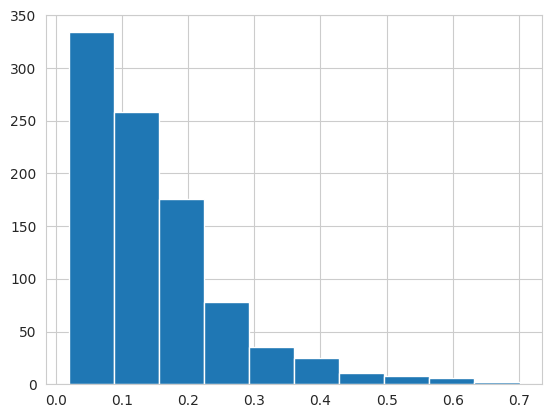

In [95]:
baseline_df["predicted_difficulty_sigmoid"].hist()

<Axes: >

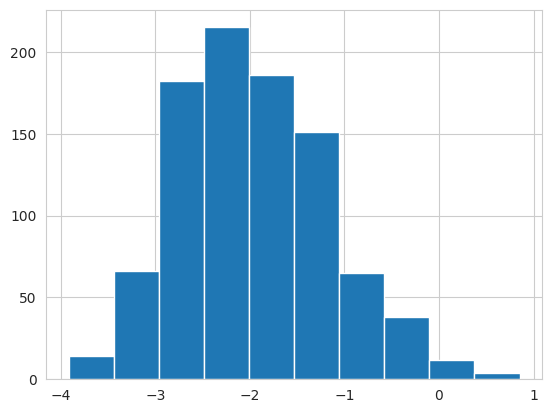

In [96]:
baseline_df["predicted_difficulty"].hist()

In [105]:
MATH_DF_PATH = "../predicting_learnability/data/MATH_{MODEL_ALIAS}-SR_{split}.parquet"

In [120]:
math_train_df = pd.read_parquet(MATH_DF_PATH.format(MODEL_ALIAS=MODEL_ALIAS, split="train"))
math_test_df = pd.read_parquet(MATH_DF_PATH.format(MODEL_ALIAS=MODEL_ALIAS, split="test"))

<Axes: >

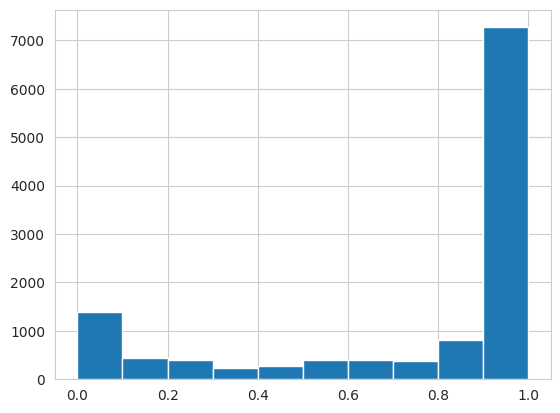

In [121]:
math_train_df["success_rate"].hist()

<Axes: >

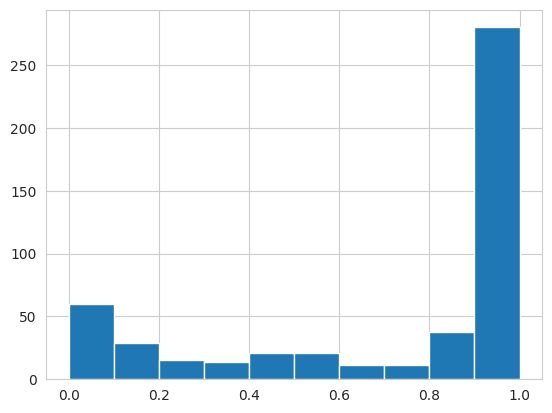

In [122]:
math_test_df["success_rate"].hist()

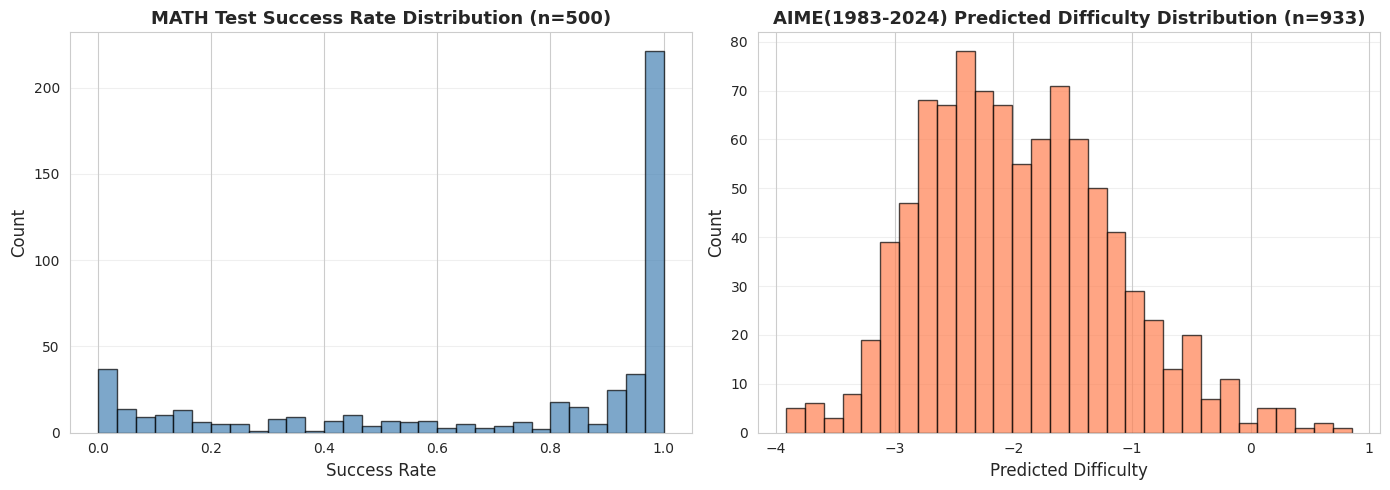

MATH Test Success Rate - Mean: 0.7155, Median: 0.9400
AIME Predicted Difficulty - Mean: -1.9578, Median: -2.0397


In [128]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: MATH test success rate
ax1 = axes[0]
math_test_df["success_rate"].hist(bins=30, ax=ax1, color='steelblue', alpha=0.7, edgecolor='black')
ax1.set_xlabel('Success Rate', fontsize=12)
ax1.set_ylabel('Count', fontsize=12)
ax1.set_title(f'MATH Test Success Rate Distribution (n={len(math_test_df)})', fontsize=13, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)


# Plot 2: AIME baseline predicted difficulty
ax2 = axes[1]
baseline_df["predicted_difficulty"].hist(bins=30, ax=ax2, color='coral', alpha=0.7, edgecolor='black')
ax2.set_xlabel('Predicted Difficulty', fontsize=12)
ax2.set_ylabel('Count', fontsize=12)
ax2.set_title(f'AIME(1983-2024) Predicted Difficulty Distribution (n={len(baseline_df)})', fontsize=13, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"MATH Test Success Rate - Mean: {math_test_df['success_rate'].mean():.4f}, Median: {math_test_df['success_rate'].median():.4f}")
print(f"AIME Predicted Difficulty - Mean: {baseline_df['predicted_difficulty'].mean():.4f}, Median: {baseline_df['predicted_difficulty'].median():.4f}")

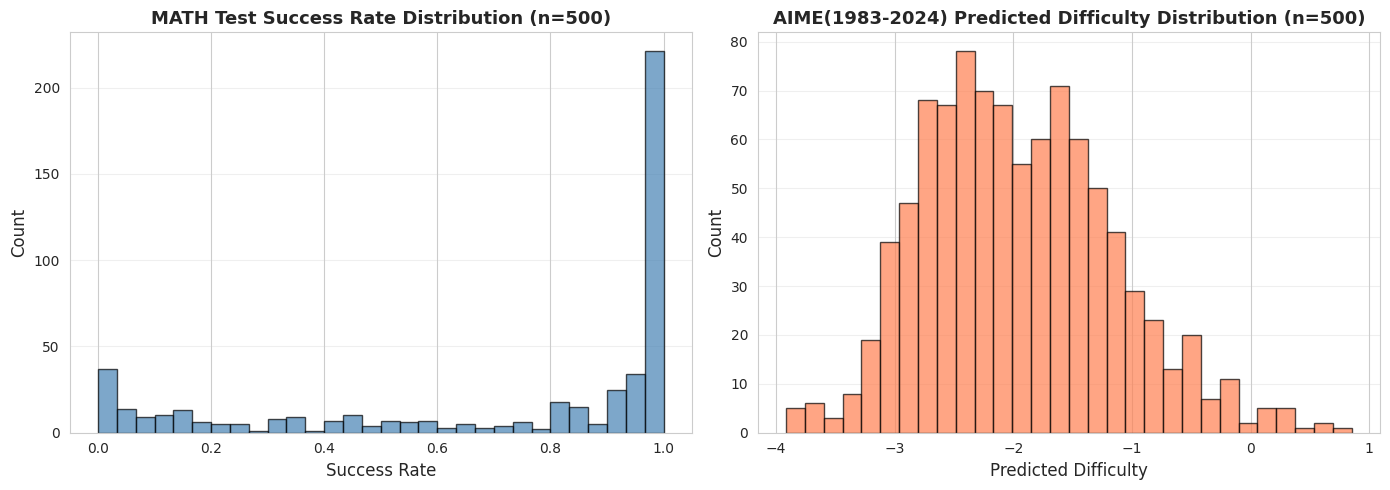

MATH Test Success Rate - Mean: 0.7155, Median: 0.9400
AIME Predicted Difficulty - Mean: -1.9578, Median: -2.0397


In [125]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: MATH test success rate
ax1 = axes[0]
math_test_df["success_rate"].hist(bins=30, ax=ax1, color='steelblue', alpha=0.7, edgecolor='black')
ax1.set_xlabel('Success Rate', fontsize=12)
ax1.set_ylabel('Count', fontsize=12)
ax1.set_title(f'MATH Test Success Rate Distribution (n={len(math_test_df)})', fontsize=13, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

sample_baseline_df = baseline_df.sample(n=len(math_test_df), random_state=42)
# Plot 2: AIME baseline predicted difficulty
ax2 = axes[1]
baseline_df["predicted_difficulty"].hist(bins=30, ax=ax2, color='coral', alpha=0.7, edgecolor='black')
ax2.set_xlabel('Predicted Difficulty', fontsize=12)
ax2.set_ylabel('Count', fontsize=12)
ax2.set_title(f'AIME(1983-2024) Predicted Difficulty Distribution (n={len(sample_baseline_df)})', fontsize=13, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"MATH Test Success Rate - Mean: {math_test_df['success_rate'].mean():.4f}, Median: {math_test_df['success_rate'].median():.4f}")
print(f"AIME Predicted Difficulty - Mean: {baseline_df['predicted_difficulty'].mean():.4f}, Median: {baseline_df['predicted_difficulty'].median():.4f}")

<Axes: >

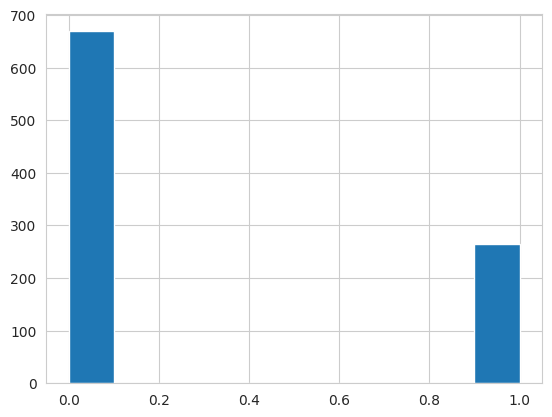

In [130]:
baseline_df["is_correct"].hist()

In [175]:
baseline_df["binary_predicted_success_rate"] = baseline_df["predicted_difficulty_sigmoid"].apply(lambda x: 1 if x >= baseline_df["predicted_difficulty_sigmoid"].mean() else 0)

<Axes: >

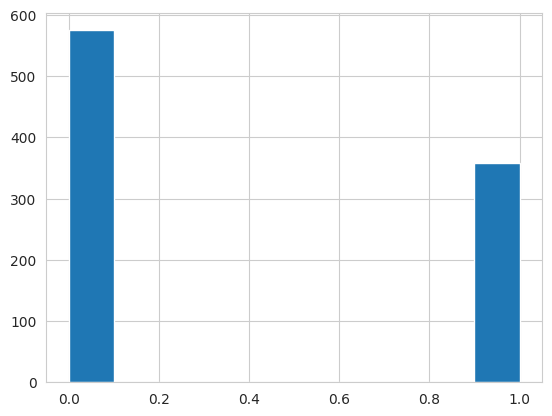

In [176]:
baseline_df["binary_predicted_success_rate"].hist()

In [177]:
accuracy_score(baseline_df["is_correct"].tolist(), baseline_df["binary_predicted_success_rate"].tolist())

0.5605573419078242

In [178]:
print(classification_report(baseline_df["is_correct"].tolist(), baseline_df["binary_predicted_success_rate"].tolist()))

              precision    recall  f1-score   support

           0       0.73      0.62      0.67       669
           1       0.30      0.40      0.34       264

    accuracy                           0.56       933
   macro avg       0.51      0.51      0.51       933
weighted avg       0.60      0.56      0.58       933



In [157]:
import matplotlib.pyplot as plt

In [167]:
BASELINE_SR = baseline_df["is_correct"].tolist()
BINARY_PREDICTED_SR = baseline_df["binary_predicted_success_rate"].tolist()
RAW_SR = baseline_df["predicted_difficulty_sigmoid"].tolist()

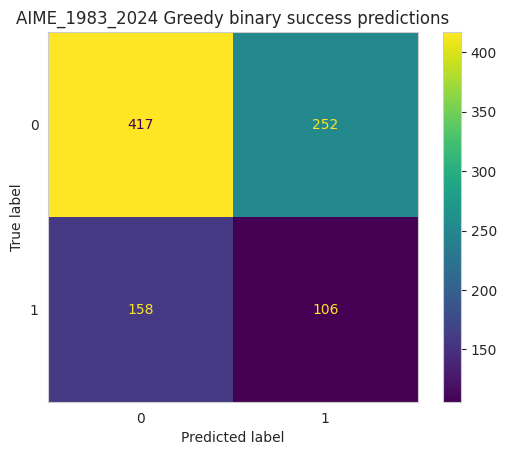

In [170]:
cm = confusion_matrix(BASELINE_SR, BINARY_PREDICTED_SR, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[0, 1])
disp.plot()
plt.title(f"{DATASET_NAME} Greedy binary success predictions")
plt.grid(False)
plt.show()

In [168]:
roc_auc_score(BASELINE_SR, RAW_SR)

0.54529600942157

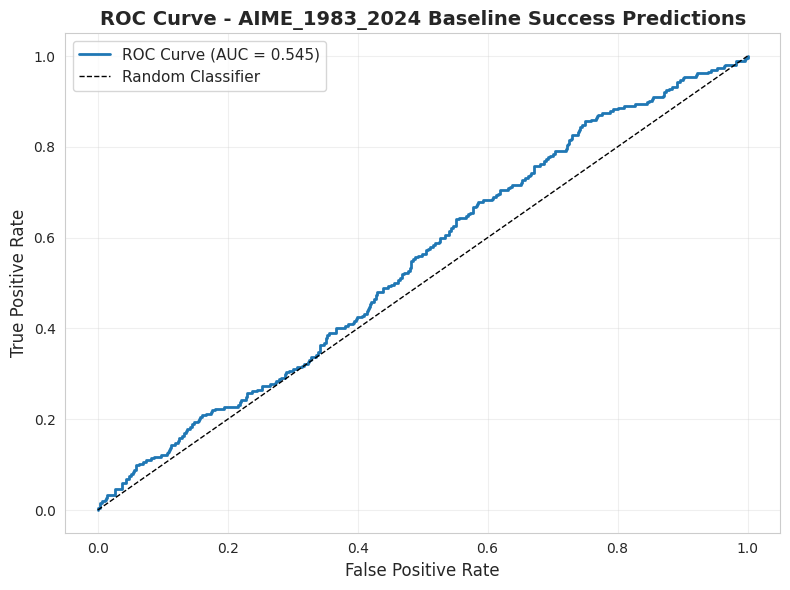

In [171]:
fpr, tpr, thresholds = roc_curve(BASELINE_SR, RAW_SR)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, linewidth=2, label=f'ROC Curve (AUC = {roc_auc_score(BASELINE_SR, RAW_SR):.3f})')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title(f'ROC Curve - {DATASET_NAME} Baseline Success Predictions', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(f'{MAJORITY_VOTE_RESULTS_DIR}/{MODEL_ALIAS}_roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()

<Axes: >

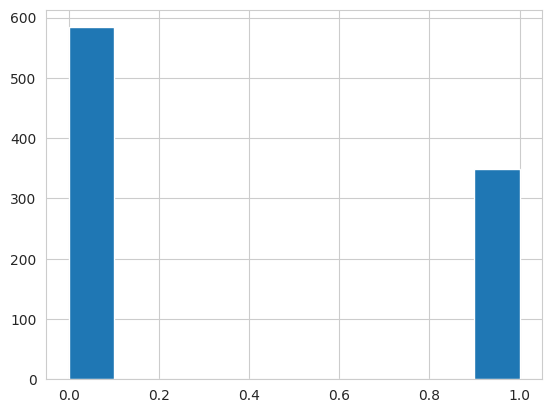

In [134]:
MAJORITY_VOTE_DF_COPY["is_correct_num"].hist()